In [34]:
import pandas as pd
import json

# load json file 
with open('course_data.json', 'r') as f:
    data = json.load(f)


df_initial = pd.DataFrame.from_dict(data, orient='index').reset_index()
df_initial.rename(columns={'index': 'course_code'}, inplace=True)

# we need reviews text and course_rating
df_exploded = df_initial.explode('reviews')


df_reviews = pd.json_normalize(df_exploded['reviews'])

df_exploded = df_exploded.reset_index(drop=True)
df = pd.concat([df_exploded[['course_code', 'course_title']], df_reviews], axis=1)


df.head(10)

,course_code,course_title,review_text,course_rating
0,CS 115,Introduction to Computer Science 1,go to office hours and practice,liked course
1,CS 115,Introduction to Computer Science 1,One of my least favourite courses. Although th...,disliked course
2,CS 115,Introduction to Computer Science 1,It starts with a very low pace but after midte...,disliked course
3,CS 115,Introduction to Computer Science 1,Took this in 2018 with no programming experien...,liked course
4,CS 115,Introduction to Computer Science 1,I loved everything about cs 115. Great instruc...,liked course
5,CS 115,Introduction to Computer Science 1,I recommend finding a course with a language t...,liked course
6,CS 115,Introduction to Computer Science 1,"I really enjoyed this course online, being co-...",liked course
7,CS 115,Introduction to Computer Science 1,math student who took this course since I had ...,disliked course
8,CS 115,Introduction to Computer Science 1,The only way to do bad in this course is by no...,liked course
9,CS 115,Introduction to Computer Science 1,"Can be difficult at times, but a very rewardin...",liked course


In [35]:
df['review_length'] = df['review_text'].astype(str).apply(len)
df['review_length'].head()

0     31
1    214
2    447
3    283
4    281
Name: review_length, dtype: int64

In [36]:
def perform_course_eda(df):
 
    df['review_length'] = df['review_text'].astype(str).apply(len)
    #Check the number of Good and Bad reviews.
    rating_counts = df['course_rating'].value_counts()
    
    #Analyze the length of the reviews.
    eda_summary = df.groupby('course_title')['review_length'].agg(
        n='count',
        mean='mean',
        median='median',
        p90=lambda x: x.quantile(0.9)
    ).reset_index()
    
   
    print("--- General Statistics ---")
    #Count the number of reviews.
    print(f"Total Number of Reviews: {len(df)}")
    print("\n--- Ratings Breakdownthe (number of liked and disliked rating) ---")
    print(rating_counts)
    print("\n--- Review Length Analysis  ---")
    
    return eda_summary


analysis_results = perform_course_eda(df)
print(analysis_results)

--- General Statistics ---
Total Number of Reviews: 21343

--- Ratings Breakdownthe (number of liked and disliked rating) ---
course_rating
liked course       9786
disliked course    4830
Name: count, dtype: int64

--- Review Length Analysis  ---
                                   course_title  n  mean  median  p90
0                16th-Century French Literature  3   3.0     3.0  3.0
1                17th-Century French Literature  3   3.0     3.0  3.0
2                       17th-Century Literature  1   3.0     3.0  3.0
3                18th-Century French Literature  3   3.0     3.0  3.0
4                       18th-Century Literature  1   3.0     3.0  3.0
...                                         ... ..   ...     ...  ...
6427                      Written Communication  1   3.0     3.0  3.0
6428                      X-Ray Crystallography  1   3.0     3.0  3.0
6429                      Youth and Adolescence  1   3.0     3.0  3.0
6430              Zeitgeist and Popular Culture  1   

In [37]:
import re
import nltk
from nltk.corpus import stopwords

# load the stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # check if the variable is a string 
    if not isinstance(text, str): return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and special characters.
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Remove Stopwords
    words = [w for w in text.split() if w not in stop_words]
    
    return " ".join(words)


print("Cleaning text... Please wait.")
df['cleaned_review'] = df['review_text'].apply(clean_text)


df[['review_text', 'cleaned_review']].head()

Cleaning text... Please wait.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_text,cleaned_review
0,go to office hours and practice,go office hours practice
1,One of my least favourite courses. Although th...,one least favourite courses although things ni...
2,It starts with a very low pace but after midte...,starts low pace midterm gets really fast canno...
3,Took this in 2018 with no programming experien...,took programming experience ever started prett...
4,I loved everything about cs 115. Great instruc...,loved everything cs great instructors fair ass...


In [38]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokens = tokenizer(
    df["cleaned_review"].tolist(),
    padding = True,
    truncation = True,
    max_length = 512, 
    return_tensors = "pt"
)



In [39]:
tokens.input_ids.shape

torch.Size([21343, 399])

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
# Map the text ratings to numerical values
df['label'] = df['course_rating'].map({'liked course': 1, 'disliked course': 0})


initial_count = len(df)
## Remove rows where the label is missing (NaN)
df = df.dropna(subset=['label'])
final_count = len(df)

print(f"Removed {initial_count - final_count} rows with missing labels.")
# Use indices to ensure the pre-computed input_ids (Tokens) match the DataFrame rows
indices = df.index
X = tokens['input_ids'][indices].numpy() 
y = df['label'].values

# Dataset Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Removed 6727 rows with missing labels.



--- Logistic Regression Results ---


c:\Users\w\Documents\my_csv_project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.66
              precision    recall  f1-score   support

         Bad       0.43      0.02      0.04       988
        Good       0.66      0.99      0.79      1936

    accuracy                           0.66      2924
   macro avg       0.55      0.50      0.42      2924
weighted avg       0.59      0.66      0.54      2924



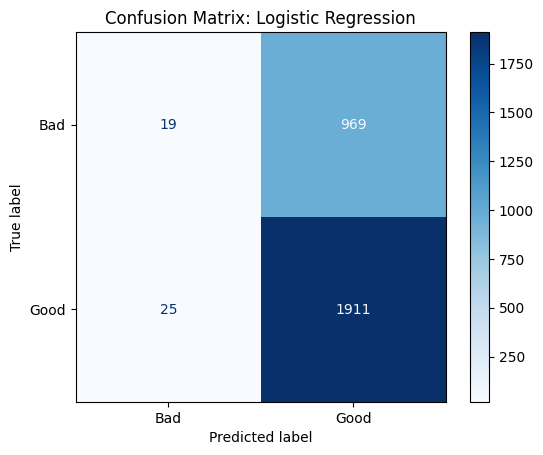


--- Random Forest Results ---
Accuracy: 0.67
              precision    recall  f1-score   support

         Bad       0.59      0.11      0.19       988
        Good       0.68      0.96      0.80      1936

    accuracy                           0.67      2924
   macro avg       0.64      0.54      0.49      2924
weighted avg       0.65      0.67      0.59      2924



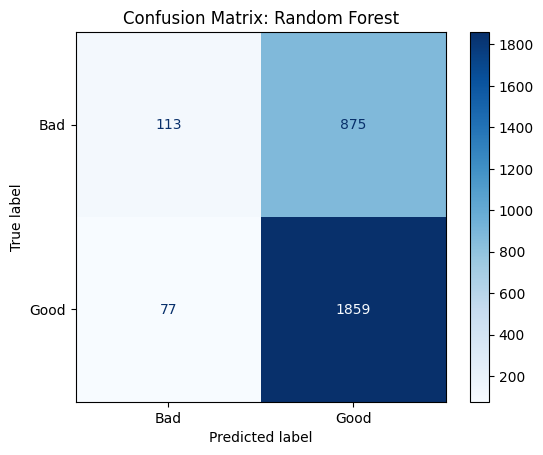


--- LinearSVC Results ---
Accuracy: 0.66
              precision    recall  f1-score   support

         Bad       0.44      0.02      0.03       988
        Good       0.66      0.99      0.79      1936

    accuracy                           0.66      2924
   macro avg       0.55      0.50      0.41      2924
weighted avg       0.59      0.66      0.54      2924



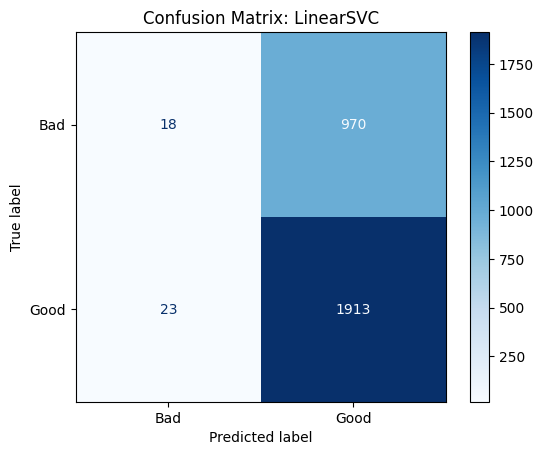

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train three classifiers to predict whether a course is Good or Bad.
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    #"SVM": SVC(kernel='linear', probability=True)
    "LinearSVC" : LinearSVC(max_iter=1000, dual=False)
}

for name, clf in classifiers.items():
    print(f"\n--- {name} Results ---")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
   
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred, target_names=['Bad', 'Good']))
    

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
    
  
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

There is an imbalance in the data  liked course (Good) 9786
disliked course(bad)    4830  , as the number of good samples is much greater than the bad ones, which made all models tend to predict "good" to ensure high accuracy, but they failed to detect the bad samples accurately.


LinearSVC and Logistic Regression performed almost identically, classifying the vast majority of reviews as "Good" and detecting only 18-19 negative reviews out of 988.

Random Forest was the most "smart" of the three, identifying 113 negative reviews.

